# Baseline Sensitivity Study for a pulse of 7keK without noise



In [13]:
# ----IMPORT MODULES --------------
from __future__ import print_function
from __future__ import division
from multiprocessing import Pool, cpu_count
from itertools import repeat
from subprocess import check_call, check_output,STDOUT
from cycler import cycler
from astropy.io import fits
from scipy.stats import norm
from statistics import mean
import math
import pandas
import sys, os
import shutil, tempfile, shlex
import re
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy.polynomial import Polynomial
import auxpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from numpy import genfromtxt

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
eurecaDir = "/dataj6/ceballos/INSTRUMEN/EURECA"
sixteDir = eurecaDir + "/testHarness/simulations/SIXTE"
sixteInst = os.environ["SIXTE"] + "/share/sixte/instruments/athena-xifu/"
#sixteInst = "/dataj4/software/SIXTE/git/gitInstall" + "/share/sixte/instruments/athena-xifu/"
xmlfile = sixteInst + "/xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml"


# Define variables 

In [14]:
pulseLength=(128,256,512,1024,1500,2048,2500,3000,3500,4096,4500, 5000, 5500, 6000,7000, 8192) # or shorter lengths
ofLength=(128,256,512,1024,2048,4096,8192) # for 0-padding or shorter filters otherwise


# ... and filenames

In [15]:
name = "pulse7keVnonoise"
name_TBhigher = "pulse7keVnonoise_TBhigher"

inputFile = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + ".fits"
inputFile_TBhigher = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name_TBhigher + ".fits"

libfile = "/dataj6/ceballos/INSTRUMEN/EURECA/testHarness/simulations/SIXTE/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/library6keV_PL8192_20000p_jitter_bbfb_NewPar.fits"
#xmlfile = "/home/EURECA/share/sixte/instruments/athena-xifu/xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml"

# a) Filenames for 0-padding 
# ========================================================
evtFs = list()
evtFs_calib = list()
evtTBFs = list()
evtTBFs_calib = list()

for i in range(0,len(pulseLength)):    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_pL" + str(pulseLength[i]) + ".fits")
    #print(file)
    evtFs.append(file)
    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_pL" + str(pulseLength[i]) + "_HR.calib")
    #print(file)
    evtFs_calib.append(file)
    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_TBhigher_pL" + str(pulseLength[i]) + ".fits")
    #print(file)
    evtTBFs.append(file)
    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_TBhigher_pL" + str(pulseLength[i]) + "_HR.calib")
    #print(file)
    evtTBFs_calib.append(file)

# a) Optimal Filtering
# =============================
evtFs_OPTFILT = list()
evtFs_calib_OPTFILT = list()
evtTBFs_OPTFILT = list()
evtTBFs_calib_OPTFILT = list()

for i in range(0,len(ofLength)):    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_OPTFILT" + str(ofLength[i]) + ".fits")
    #print(file)
    evtFs_OPTFILT.append(file)
    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_OPTFILT" + str(ofLength[i]) + "_HR.calib")
    #print(file)
    evtFs_calib_OPTFILT.append(file)
    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_TBhigher_OPTFILT" + str(ofLength[i]) + ".fits")
    #print(file)
    evtTBFs_OPTFILT.append(file)
    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_TBhigher_OPTFILT" + str(ofLength[i]) + "_HR.calib")
    #print(file)
    evtTBFs_calib_OPTFILT.append(file)

# Run 0-padding


In [25]:
# RECONSTRUCT by using 0-padding
run = 1
if run:
    for i in range(0,len(pulseLength)):
        if not os.path.isfile(evtFs[i]):
            comm = ("tesreconstruction Recordfile=" + inputFile + " TesEventFile=" + evtFs[i] + " Rcmethod=SIRENA" + 
                " PulseLength="+ str(pulseLength[i]) + " LibraryFile=" + libfile +
                " samplesUp=3" + " nSgms=3.5" + " samplesDown=4" + 
                " opmode=1 OFLib=yes FilterDomain=T" + " detectionMode=STC Fitting35=3" + 
                " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT" + 
                " LagsOrNot=1" +
                " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=8192")
            try:
                print("Reconstructing: ", evtFs[i])
                print(comm)
                args = shlex.split(comm)
                check_call(args, stderr=STDOUT)
            except:
                print("Error running tool for SIRENA reconstruction with command:\n", comm)
                shutil.rmtree(tmpDir)
                raise
        if not os.path.isfile(evtTBFs[i]):
            comm = ("tesreconstruction Recordfile=" + inputFile_TBhigher + " TesEventFile=" + evtTBFs[i] + " Rcmethod=SIRENA" + 
                " PulseLength="+ str(pulseLength[i]) + " LibraryFile=" + libfile +
                " samplesUp=3" + " nSgms=3.5" + " samplesDown=4" + 
                " opmode=1 OFLib=yes FilterDomain=T" + " detectionMode=STC Fitting35=3" + 
                " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT" + 
                " LagsOrNot=1" +
                " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=8192")
            try:
                print("Reconstructing: ", evtTBFs[i])
                print(comm)
                args = shlex.split(comm)
                check_call(args, stderr=STDOUT)
            except:
                print("Error running tool for SIRENA reconstruction with command:\n", comm)
                shutil.rmtree(tmpDir)
                raise

Reconstructing:  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_pL128.fits
tesreconstruction Recordfile=/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise.fits TesEventFile=/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_pL128.fits Rcmethod=SIRENA PulseLength=128 LibraryFile=/dataj6/ceballos/INSTRUMEN/EURECA/testHarness/simulations/SIXTE/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/library6keV_PL8192_20000p_jitter_bbfb_NewPar.fits samplesUp=3 nSgms=3.5 samplesDown=4 opmode=1 OFLib=yes FilterDomain=T detectionMode=STC Fitting35=3 FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT LagsOrNot=1 XMLFile=/home/EURECA/simulations/SIXTE/git/gitInstall/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml filtEeV=6000.0 OFStrategy=FIXED OFLength=8192
Reconstructing:  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_TBhigher_pL128

# Run OPTIMAL FILTER


In [26]:
# RECONSTRUCT by using OPTIMAL FILTERING
run = 1
if run:
    for i in range(0,len(ofLength)):
        comm = ("tesreconstruction Recordfile=" + inputFile + " TesEventFile=" + evtFs_OPTFILT[i] + " Rcmethod=SIRENA" + 
            " PulseLength=8192" + " LibraryFile=" + libfile +
            " samplesUp=3" + " nSgms=3.5" + " samplesDown=4" + 
            " opmode=1 OFLib=yes FilterDomain=T" + " detectionMode=STC Fitting35=3" + 
            " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT" + 
            " LagsOrNot=1" +
            " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(ofLength[i]))
        try:
            print("Reconstructing: ", evtFs_OPTFILT[i])
            print(comm)
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for SIRENA reconstruction with command:\n", comm)
            shutil.rmtree(tmpDir)
            raise
                
        comm = ("tesreconstruction Recordfile=" + inputFile_TBhigher + " TesEventFile=" + evtTBFs_OPTFILT[i] + " Rcmethod=SIRENA" + 
            " PulseLength=8192" + " LibraryFile=" + libfile +
            " samplesUp=3" + " nSgms=3.5" + " samplesDown=4" + 
            " opmode=1 OFLib=yes FilterDomain=T" + " detectionMode=STC Fitting35=3" + 
            " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT" + 
            " LagsOrNot=1" +
            " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(ofLength[i]))
        try:
            print("Reconstructing: ", evtTBFs_OPTFILT[i])
            print(comm)
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for SIRENA reconstruction with command:\n", comm)
            shutil.rmtree(tmpDir)
            raise

Reconstructing:  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_OPTFILT128.fits
tesreconstruction Recordfile=/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise.fits TesEventFile=/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_OPTFILT128.fits Rcmethod=SIRENA PulseLength=8192 LibraryFile=/dataj6/ceballos/INSTRUMEN/EURECA/testHarness/simulations/SIXTE/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/library6keV_PL8192_20000p_jitter_bbfb_NewPar.fits samplesUp=3 nSgms=3.5 samplesDown=4 opmode=1 OFLib=yes FilterDomain=T detectionMode=STC Fitting35=3 FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT LagsOrNot=1 XMLFile=/home/EURECA/simulations/SIXTE/git/gitInstall/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml filtEeV=6000.0 OFStrategy=FIXED OFLength=128
Reconstructing:  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_TBhi

# CALIBRATE 0-padding files


In [19]:
run = 1
if run:
    coeffsFile = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit.dat"
    for i in range(0,len(pulseLength)):
        alias = "pL" + str(pulseLength[i]) + "_STC_T_fixedlib6OF_OPTFILT8192_jitter_bbfb"
        auxpy.convertEnergies(evtFs[i],evtFs_calib[i],coeffsFile,alias)
        
        auxpy.convertEnergies(evtTBFs[i],evtTBFs_calib[i],coeffsFile,alias)

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_pL128.fits
Reading curve coefficients from /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit.dat 

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_TBhigher_pL128.fits
Reading curve coefficients from /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit.dat 

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_pL256.fits
Reading curve coefficients from /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit.dat 

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_TBhigher_pL256.fits
Reading curve coefficients from /dataj6/ceballos/INSTRUMEN/EUREC

KeyError: 'pL1500_STC_T_fixedlib6OF_OPTFILT8192_jitter_bbfb'

# CALIBRATE OPTIMAL FILTERING files


In [20]:
run = 1
if run:
    coeffsFile = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit.dat"
    for i in range(0,len(ofLength)):
        alias = "pL8192_STC_T_fixedlib6OF_OPTFILT" + str(ofLength[i]) + "_jitter_bbfb"
        auxpy.convertEnergies(evtFs_OPTFILT[i],evtFs_calib_OPTFILT[i],coeffsFile,alias)
        
        auxpy.convertEnergies(evtTBFs_OPTFILT[i],evtTBFs_calib_OPTFILT[i],coeffsFile,alias)

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_OPTFILT128.fits
Reading curve coefficients from /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit.dat 

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_TBhigher_OPTFILT128.fits
Reading curve coefficients from /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit.dat 

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_OPTFILT256.fits
Reading curve coefficients from /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit.dat 

...Calculating corrected energies for pulses in  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_TBhigher_OPTFILT256.fits
Reading curve coefficients from /dataj6/ceba

# Plot the OPTIMAL FILTERING baseline sensitivity

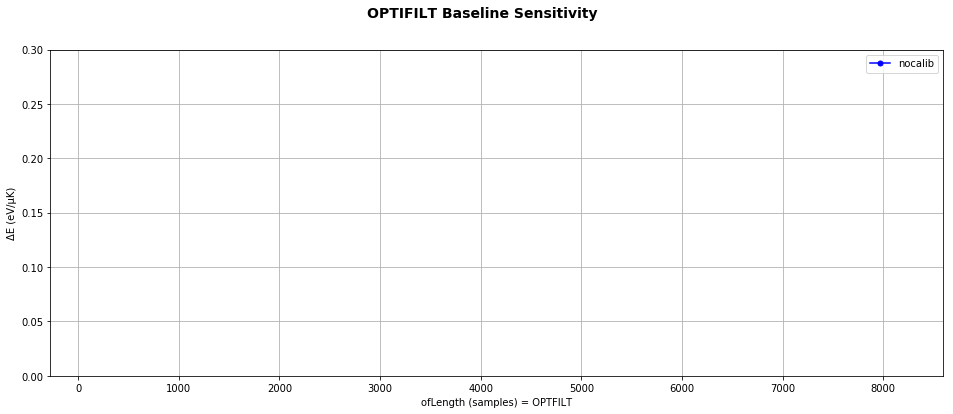

In [21]:
run = 1
if run:
    fig = plt.figure(figsize=(16,6))
    fig.suptitle('OPTIFILT Baseline Sensitivity', fontsize=14, fontweight='bold')
    
    # No calibrated
    nocalib_OPTFILT = list()
    TBhigher_nocalib_OPTFILT = list()
    
    calib_OPTFILT = list()
    TBhigher_calib_OPTFILT = list()
    
    for i in range (0,len(ofLength)):
        file = fits.open(evtFs_OPTFILT[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        nocalib_OPTFILT.append(fileSIGNAL[0])
    
        file = fits.open(evtTBFs_OPTFILT[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        TBhigher_nocalib_OPTFILT.append(fileSIGNAL[0])
        
        #file = fits.open(evtFs_calib_OPTFILT[i], memmap=True)
        #fileTab = file[1].data
        #fileSIGNAL = fileTab['SIGNAL']
        #file.close()
        
        #calib_OPTFILT.append(fileSIGNAL[0])
    
        #file = fits.open(evtTBFs_calib_OPTFILT[i], memmap=True)
        #fileTab = file[1].data
        #fileSIGNAL = fileTab['SIGNAL']
        #file.close()
        
        #TBhigher_calib_OPTFILT.append(fileSIGNAL[0])
        
    AE_eV_nocalib_OPTFILT = list()
    #AE_eV_calib_OPTFILT = list()
    for i in range(0,len(ofLength)):
        AE_eV_nocalib_OPTFILT.append(abs(nocalib_OPTFILT[i]-TBhigher_nocalib_OPTFILT[i])*1e3/0.1) # +0.1uK TBhigher with respect to TB=55mK
        #AE_eV_calib_OPTFILT.append(abs(calib_OPTFILT[i]-TBhigher_calib_OPTFILT[i])*1e3/0.1) # +0.1uK TBhigher with respect to TB=55mK
    
    plt.plot(ofLength,AE_eV_nocalib_OPTFILT, marker='o', linestyle='solid', ms=5,label='nocalib',color='blue')
    #plt.plot(ofLength,AE_eV_calib_OPTFILT, marker='v', linestyle='dotted', ms=5,label='calib',color='blue')
    #plt.plot(512,(3.17370410616157-3.17360568817963)*1e3,'or',  ms=5,label='Sum0Filt=1 nocalib')
    #plt.plot(512,(6.99757955314489-6.99718615454381)*1e3, 'vr',  ms=5,label='Sum0Filt=1 calib')
    
    plt.legend()
    plt.ylabel('ΔE (eV/µK)')
    plt.xlabel('ofLength (samples) = OPTFILT')
    plt.grid(True)

    plt.ylim(0.,0.3)

    plt.show()
    

# Plot the 0-padding baseline sensitivity

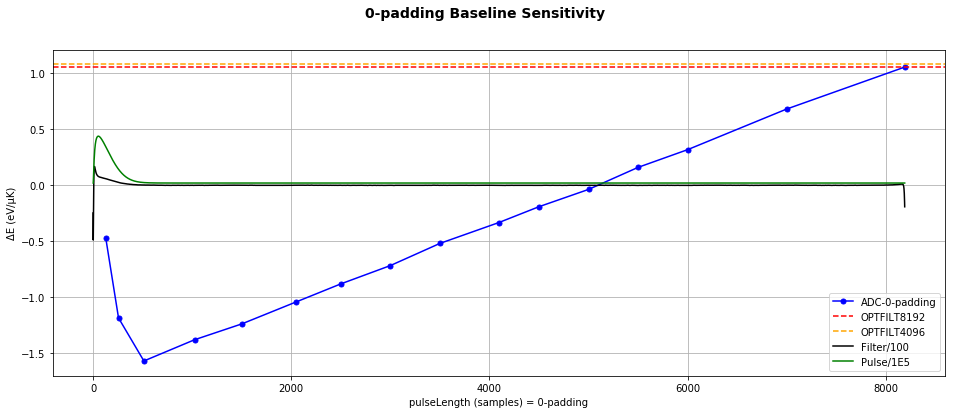

In [29]:
run = 1
if run:
    fig = plt.figure(figsize=(16,6))
    fig.suptitle('0-padding Baseline Sensitivity', fontsize=14, fontweight='bold')
    
    # #Read opt filt in T
    libDir = eurecaDir + "/testHarness/simulations/SIXTE/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/"
    ft = genfromtxt(libDir + 'library6keV_PL8192_20000p_jitter_bbfb_FT8192.txt', delimiter=" ")
    pl = genfromtxt(libDir + 'library6keV_PL8192_20000p_jitter_bbfb_pulse.txt', delimiter=" ")
    
    # No calibrated
    nocalib = list()
    TBhigher_nocalib = list()
    
    calib = list()
    TBhigher_calib = list()
    
    for i in range (0,len(pulseLength)):
        file = fits.open(evtFs[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        nocalib.append(fileSIGNAL[0])
    
        file = fits.open(evtTBFs[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        TBhigher_nocalib.append(fileSIGNAL[0])
        
        #file = fits.open(evtFs_calib[i], memmap=True)
        #fileTab = file[1].data
        #fileSIGNAL = fileTab['SIGNAL']
        #file.close()
        
        #calib.append(fileSIGNAL[0])
    
        #file = fits.open(evtTBFs_calib[i], memmap=True)
        #fileTab = file[1].data
        #fileSIGNAL = fileTab['SIGNAL']
        #file.close()
        
        #TBhigher_calib.append(fileSIGNAL[0])
        
    AE_eV_nocalib = list()
    AE_eV_nocalib_rel = list()
    AE_eV_calib = list()
    for i in range(0,len(pulseLength)):
        AE_eV_nocalib.append((nocalib[i]-TBhigher_nocalib[i])*1e3/0.1) # +0.1uK TBhigher with respect to TB=55mK
        AE_eV_nocalib_rel.append(100*AE_eV_nocalib[i]/(nocalib[i]*1e3))
        #AE_eV_calib.append(abs(calib[i]-TBhigher_calib[i])*1e3/0.1) # +0.1uK TBhigher with respect to TB=55mK
    
    plt.plot(pulseLength,AE_eV_nocalib, marker='o', linestyle='solid', ms=5,label='ADC-0-padding',color='blue')
    #plt.plot(pulseLength,AE_eV_calib, marker='v', linestyle='dotted', ms=5,label='calib',color='blue')
    #plt.plot(512,(3.17370410616157-3.17360568817963)*1e3,'or',  ms=5,label='Sum0Filt=1 nocalib')
    #plt.plot(512,(6.99757955314489-6.99718615454381)*1e3, 'vr',  ms=5,label='Sum0Filt=1 calib')
    #plt.plot(8192,AE_eV_nocalib_OPTFILT[6], 'vr',  ms=5,label='8192 OPTFILT')
    plt.axhline(y=AE_eV_nocalib_OPTFILT[6],linestyle='--',color='red',label="OPTFILT8192")
    plt.axhline(y=AE_eV_nocalib_OPTFILT[5],linestyle='--',color='orange',label="OPTFILT4096")
    plt.plot(list(range(0,8192)),ft/100,linestyle='-',color='black',label="Filter/100")
    plt.plot(list(range(0,8192)),pl/1E5,linestyle='-',color='green',label="Pulse/1E5")
    #plt.ylim(-0.1,0.45)

    plt.legend()
    plt.ylabel('ΔE (eV/µK)')
    plt.xlabel('pulseLength (samples) = 0-padding')
    plt.grid(True)

    #plt.ylim(0.001,0.2)

    plt.show()
    #fig.savefig('baselineSensitivity0padding_zoom.png', dpi=fig.dpi)
    
    # plot differences in %
    #------------------------
    #plt.plot(pulseLength,AE_eV_nocalib_rel, marker='o', linestyle='solid', ms=5,label='ADC-0-padding',color='blue')
    #plt.legend()
    #plt.ylabel('ΔE/E (%)')
    #plt.xlabel('pulseLength (samples) = 0-padding')
    #plt.grid(True)
    #plt.show()
    #for il in range(0,len(pulseLength)):
    #    print("ΔE 0-padding(",pulseLength[il],"):",AE_eV_nocalib[il],
    #          " eV =>",AE_eV_nocalib[il]/(nocalib[il]*1e3)*100,"%")
    #print("ΔE(8192)OPTFILT:",AE_eV_nocalib_OPTFILT[-1]," eV =>",
    #      AE_eV_nocalib_OPTFILT[-1]/(nocalib_OPTFILT[-1]*1e3)*100,"%")
    